# Overview of <code>adiapy</code> tools for VDF analysis
___
![illustration](graphics/illustration_nb_0.png)
___
The present Notebook illustrates the possibilities offered by <code>aidapy</code> for handling and analysing particle Velocity Distribution Functions (VDFs) observed by the Magnetospheric MultiScale (MMS) mission.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
import sys, os
import warnings
warnings.filterwarnings('ignore')

## Regular <code>aidapy</code> setup
We first import the data loading utilities (<code>aidapy</code> and <code>heliopy</code>) and the xarray classes/accessors.

In [2]:
from aidapy import load_data
import aidapy.aidaxr

We select global start and end times for the data to be loaded. A sub-selection is allowed later for finer analyses. But a time selection shorter than the duration of a single file results in no file being loaded at all.

In [3]:
start_time = datetime(2019, 3, 8, 13, 54, 53)
end_time   = datetime(2019, 3, 8, 13, 57, 0)

The <code>settings</code> dictionnary allows us to define the products we want to load. In this example, we will load the ion and electron VDFs via the keywords <code>i_dist</code> and <code>e_dist</code>, the (fluxgate) magnetic field (<code>dc_mag</code>), some spacecraft attitude products (<code>sc_att</code>) and the ion bulk velocity <code>i_bulkv</code>.

In [4]:
settings = {'prod': ['i_dist', 'e_dist', 'dc_mag', 'sc_att', 'i_bulkv'],
            'probes': ['1'], 'coords': 'gse', 'mode': 'high_res', 'frame':'gse'}

The data are loaded with the following call of <code>load_data</code>:

In [5]:
xr_mms = load_data(mission='mms', start_time=start_time, end_time=end_time, **settings)

The previous steps are shared by all applications using <code>aidapy</code>, though the precise products vary between the applications.

## Probes positions
We can easely get a quick global view of the probes' positions for the chosen time interval using the SDC plots. We find that between 13:00:00 and 14:00:00, the probes were in the magnetosheath.

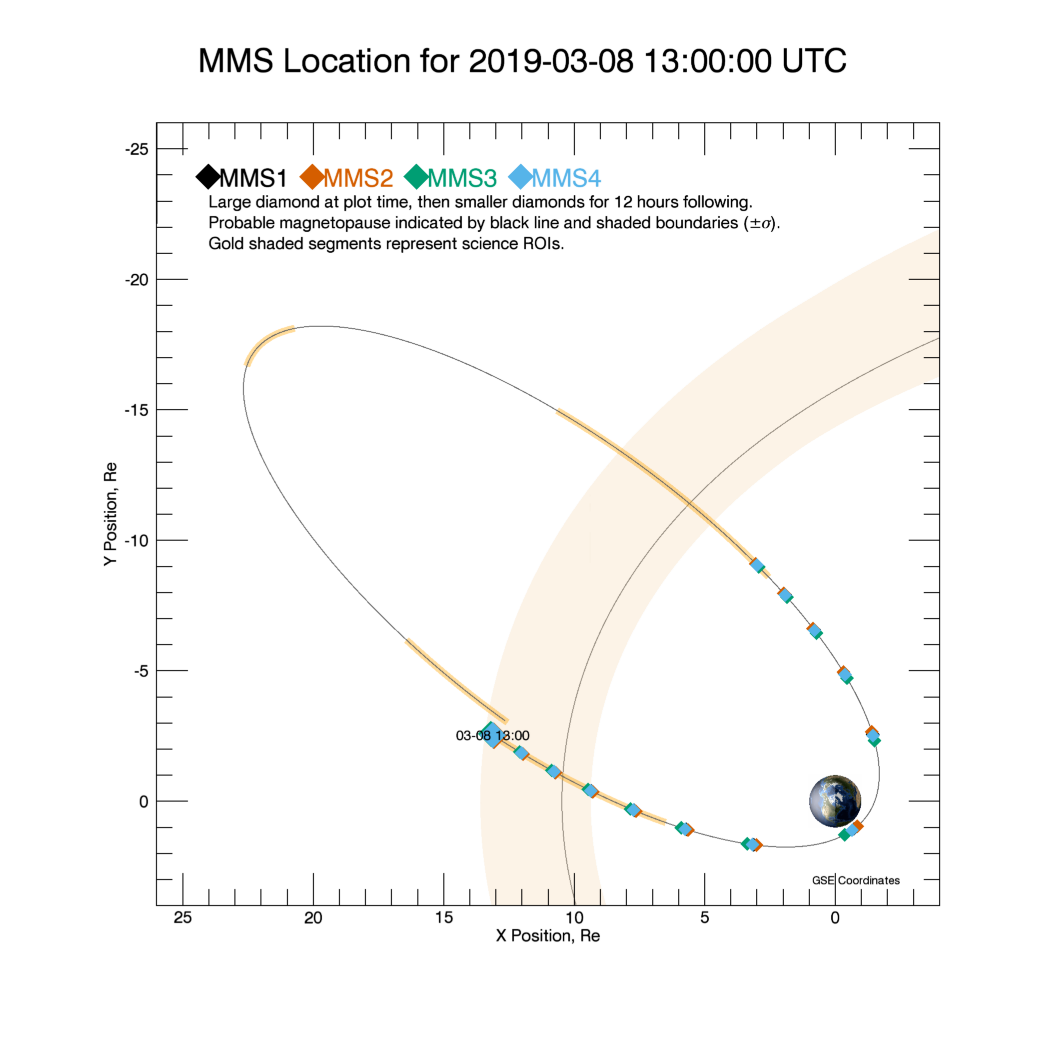

In [6]:
url_sdc = 'https://lasp.colorado.edu/mms/sdc/public/data/sdc/mms_orbit_plots/'
url_sdc += 'mms_orbit_plot_{:4d}{:02d}{:02d}{:02d}0000.png'.format(start_time.year, start_time.month, start_time.day, start_time.hour)
Image(url=url_sdc, embed=True)

## VDF-specific <code>aidapy</code> features
Next, we will explore the possibilities offered by the librairy for VDFs interpolation and visualisations. <code>aidapy</code> visualisation tools only handle *interpolated* VDFs.
### Setting up and running the interpolation
To set up the interpolation, we first select the species of interest, the frame of interest in which we want to visualise the VDFs (available are the instrument frame <code>instrument</code> and the B-aligned frame <code>B</code>), the coordinate system/geometry of the interpolation grid (cartesian <code>cart</code>, spherical <code>spher</code> or cylindrical <code>cyl</code>), its maximum extent in terms of speed and its resolution, and the method used for the interpolation, to chose between nearest-neighbour (<code>near</code>), trilinear (<code>lin</code>) and tricubic (<code>cub</code>).

In [7]:
species      = 'electron'
frame        = 'B'
grid_geom    = 'spher'
v_max        = 1.2e7
resolution   = 100
interp_schem = 'lin'

Additionaly, one can select a sub-interval of time, shorter than the overall interval defined before loading the data.

In [8]:
start_time_sub = datetime(start_time.year, start_time.month, start_time.day, 13, 55, 0, 100000)
end_time_sub   = datetime(start_time.year, start_time.month, start_time.day, 13, 55, 1, 500000)

The interpolation method is now called with the defined parameters. Depending on the chosen resolution and the chosen interpolating method, the interpolation may take quite some time. The index of the current distribution being interpolated is shown and updated every 10 VDF.

In [9]:
xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                        species=species, frame=frame, grid_geom=grid_geom,
                        v_max=v_max, resolution=resolution, interp_schem=interp_schem)



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    spher
| Resolution:       100
| Interpolation:    lin
| Start time:       2019-03-08T13:55:00.115349000
| Stop time :       2019-03-08T13:55:01.525361000
| Ind. start-stop:  237-284
| Nb distributions: 47
|____________________________________________________________


280/4234 (current VDF/nb total VDFs)
Total runtime: 14 s.



The output of the method indicates that with the chosen sub-interval, 47 distributions were interpolated, with their corresponding indices in the original data file/arrays.

### Visualisations

A few visualisations are offered by the <code>aidaxr.graphical</code> module, and are all illustrated below. The first one uses the spherical geometry of the grid to display the parallel and perpedicular 1D profiles of the VDF averaged over time, in this case 35 times 30 ms. The striking feature of these profiles are the arcs appearing for medium to high velocities. These are visual artifacts due to the linear interpolation, resulting in straight segments between two measurment points, and in arc segments in a logarithmic scale.

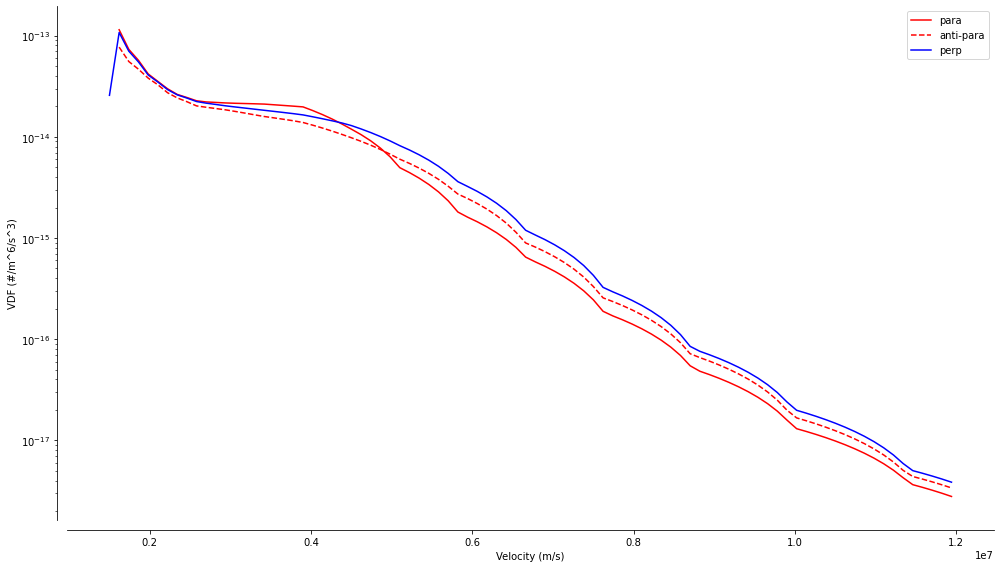

In [10]:
xr_mms.vdf.plot('1d')

The main new possibility offered by the library is the visualisation of the distribution using a *scaled* view and a *normalised* view, aiming at highlighting features of a VDF by getting rid of its high gradients, without using additional information (VDF at some other time, or fitting procedures). These views can be displayed using the <code>vdf_spher()</code> method, within the $v_{para}, v_{perp})$-plane. the <code>plt_contourf</code> keyword (boolean) toggles the use of a filled contour representation implemented in <code>matplotib.pyplot</code>

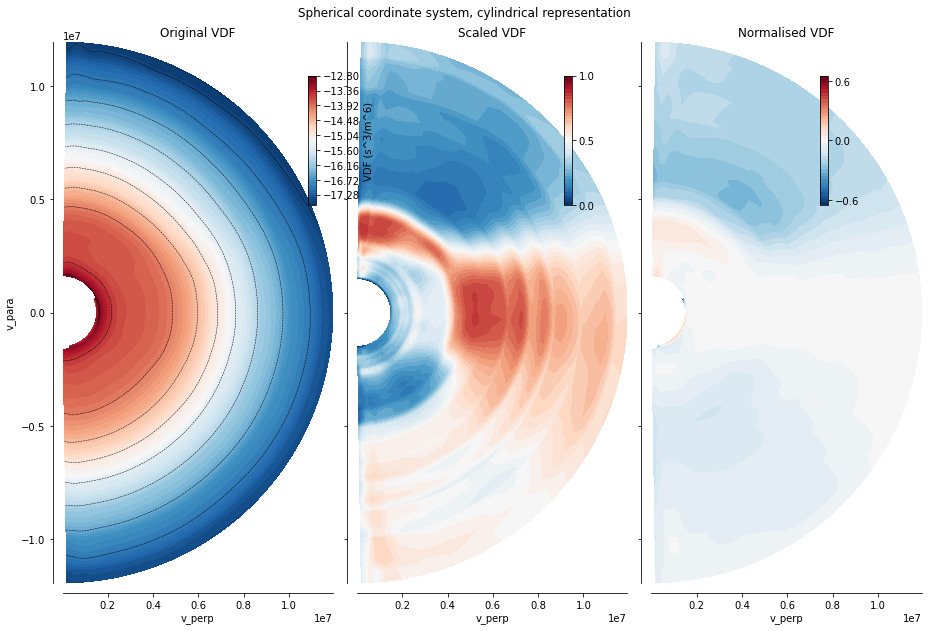

In [11]:
xr_mms.vdf.plot('2d', plt_contourf=True)

A cylindrical average is often used to display the data in the ($v_{para}, v_{perp})$-plane. For quickly checking that the VDF does not present obvious departure from gyrotropy, the following <code>vdf_gyro()</code> method displays the *equatorial* cut of the VDF (left-most full circular plot), and four angular segment of the spherical grid, their angular range displayed in the left-most plot by the dashed lines. The first row displays the original interpolated VDF values, the second row presents the scaled values. We see in this representation that the characteristic double branch feature seen in the scaled view is indeed gyrotropic.

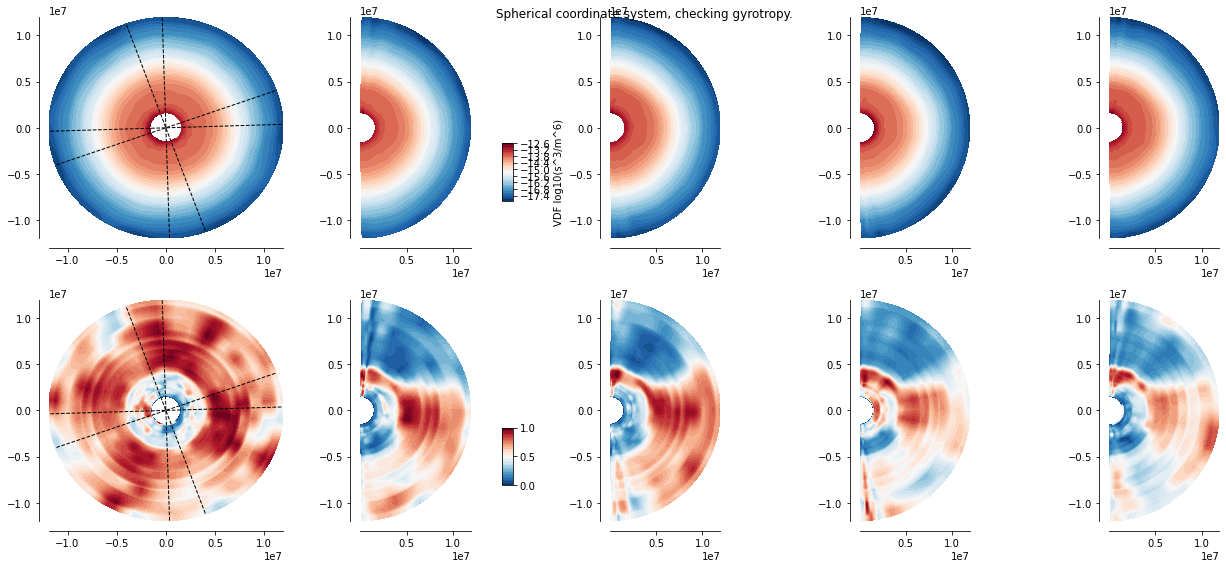

In [12]:
xr_mms.vdf.plot('3d_gyro')

These three first methods operate a time average over the entire sub-selection (from <code>start_time_sub</code> to <code>end_time_sub</code>). <code>vdf_spher_time</code> retain the time dimension, by splitting the energy/speed dimension in 5 intervals and averaging the scaled VDF over speed, over each of these intervals. The result, namely five *scaled* pitch-angle distributions, is close to what would be obtained by a classical pitch-angle distributions. We see in this example the 35 distributions along time, and check that the double branch signature is consistently found through time.

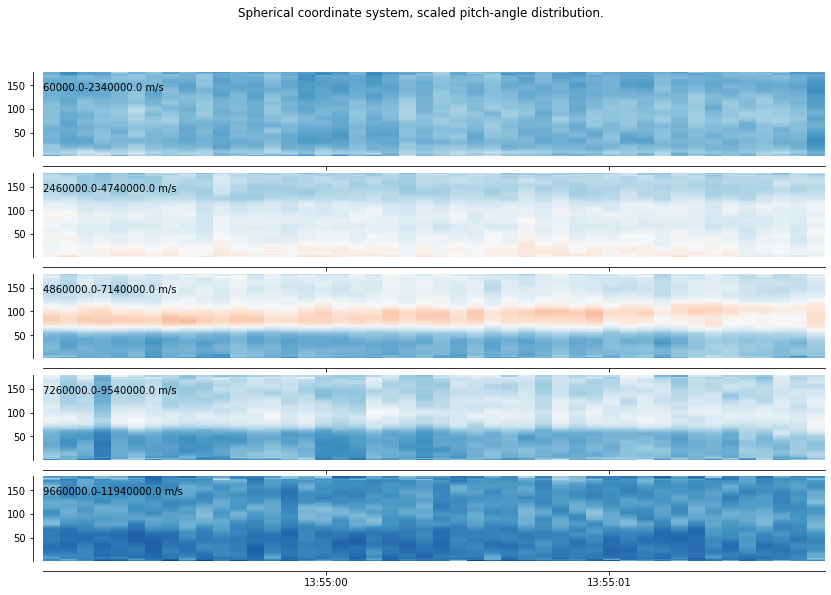

In [13]:
xr_mms.vdf.plot('3d_time', plt_contourf=False)

### Changing parameters and re-interpolating VDFs

We show now that using the exact same loaded data, one can reset the parameters, change the species, the resolution, the interpolation scheme, etc., and re-interpolate the VDFs. Note that the time sub-interval can be redefined here. In this example however, we keep the same time selection to compare electrons and ions.

In [14]:
grid_geom  = 'cart'
species    = 'ion'
resolution = 120
v_max      = 8.e5

The interpolating method is called exactly the same way as previously. Because of the difference of measurement cadence, we only get 7 distributions in this case, with a corresponding gain in time.

In [16]:
xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                        species=species, frame=frame, grid_geom=grid_geom,
                        v_max=v_max, resolution=resolution, interp_schem=interp_schem)



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    cart
| Resolution:       120
| Interpolation:    lin
| Start time:       2019-03-08T13:55:00.235349000
| Stop time :       2019-03-08T13:55:01.585361000
| Ind. start-stop:  48-57
| Nb distributions: 9
|____________________________________________________________


50/847 (current VDF/nb total VDFs)
Total runtime: 4 s.



A cartesian coordinate system is much less handy when it comes to representation and selections. Only one plotting method is offered in this case, which provides cuts through the time average VDF, with iso-contours.

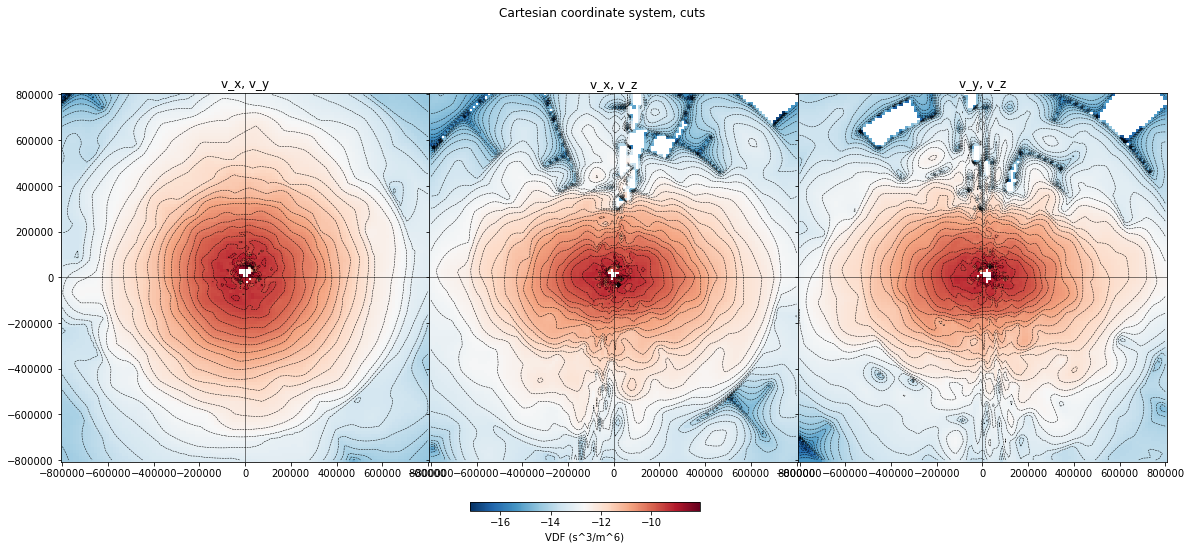

In [17]:
xr_mms.vdf.plot('3d')

### Manual handling of the interpolated VDFs

Until now, the user has only been calling methods and hasn't been manipulating the various products. We breifly illustrate here how to access the products, in order to code specific representations, or implement some further analyses. We also refer to the source scripts of each of the above plotting methods for more detailled use cases.

Let's first check the content of the dataset <code>xr_mms</code>:

In [18]:
xr_mms

<xarray.Dataset>
Dimensions:                   (mms1_des_energy_brst: 32, mms1_des_phi_brst: 32, mms1_des_theta_brst: 16, mms1_dis_bulkv_gse_brst: 3, mms1_dis_energy_brst: 32, mms1_dis_phi_brst: 32, mms1_dis_theta_brst: 16, mms1_fgm_b_gse_brst_l2: 4, mms1_mec_quat_eci_to_gse: 4, phi: 120, speed: 120, theta: 120, time: 9, time1: 847, time2: 4234, time3: 16253, time4: 5, time5: 847, v: 3, v_para: 120, v_perp: 120, vx: 120, vy: 120, vz: 120)
Coordinates:
  * mms1_dis_energy_brst      (mms1_dis_energy_brst) float32 2.16 ... 17800.0
  * mms1_dis_phi_brst         (mms1_dis_phi_brst) float32 7.0 18.25 ... 355.75
  * mms1_dis_theta_brst       (mms1_dis_theta_brst) float32 5.625 ... 174.375
  * time1                     (time1) datetime64[ns] 2019-03-08T13:54:53.035267 ... 2019-03-08T13:56:59.936741
  * mms1_des_theta_brst       (mms1_des_theta_brst) float32 5.625 ... 174.375
  * mms1_des_phi_brst         (mms1_des_phi_brst) float32 5.375 ... 354.125
  * mms1_des_energy_brst      (mms1_des_energy_brst) float32 6.52 ... 27525.0
  * time2                     (time2) datetime64[ns] 2019-03-08T13:54:53.005267 ... 2019-03-08T13:56:59.996741
  * mms1_fgm_b_gse_brst_l2    (mms1_fgm_b_gse_brst_l2) <U3 'x' 'y' 'z' 'tot'
  * time3                     (time3) datetime64[ns] 2019-03-08T13:54:53.024982 ... 2019-03-08T13:56:59.995838
  * mms1_mec_quat_eci_to_gse  (mms1_mec_quat_eci_to_gse) <U3 'x' 'y' 'z' 'tot'
  * time4                     (time4) datetime64[ns] 2019-03-08T13:55:00 ... 2019-03-08T13:57:00
  * mms1_dis_bulkv_gse_brst   (mms1_dis_bulkv_gse_brst) <U1 'x' 'y' 'z'
  * time5                     (time5) datetime64[ns] 2019-03-08T13:54:53.035267 ... 2019-03-08T13:56:59.936741
Dimensions without coordinates: phi, speed, theta, time, v, v_para, v_perp, vx, vy, vz
Data variables:
    i_dist1                   (time1, mms1_dis_energy_brst, mms1_dis_theta_brst, mms1_dis_phi_brst) float32 0.0 ... 0.0
    e_dist1                   (time2, mms1_des_energy_brst, mms1_des_theta_brst, mms1_des_phi_brst) float32 1.2165267e-25 ... 0.0
    dc_mag1                   (time3, mms1_fgm_b_gse_brst_l2) float32 -0.29875872 ... 41.451748
    sc_att1                   (time4, mms1_mec_quat_eci_to_gse) float64 -0.2019 ... 0.9733
    i_bulkv1                  (time5, mms1_dis_bulkv_gse_brst) float32 4.4563413 ... -76.759415
    vdf_interp_time           (time, vx, vz) float32 1.2914518e-15 ... 2.6537375e-16
    vdf_interp                (vx, vy, vz) float64 3.526e-16 ... 2.228e-15
    grid_interp_cart          (v, vx, vy, vz) float32 -800000.0 ... 800000.0
    grid_interp_spher         (v, speed, theta, phi) float32 1385640.6 ... 0.7853982
    grid_interp_cyl           (v, v_perp, phi, v_para) float32 1131370.9 ... 800000.0
    time_interp               (time) datetime64[ns] 2019-03-08T13:55:00.235349 ... 2019-03-08T13:55:01.435361
    grid_geom                 <U4 'cart'
Attributes:
    mission:        mms
    load_settings:  {'prod': ['i_dist', 'e_dist', 'dc_mag', 'sc_att', 'i_bulk...

One can spot the four variables added by the execution of <code>interpolate()</code> method: <code>distrib_interp</code>, <code>grid_interp_spher</code>, <code>grid_interp_cart</code> and <code>time_interp</code> .  <code>grid_*</code> variables are three dimensional grids giving three coordinates for each of the VDF values. We can get the 1D arrays of the centers of the bins as shown here:

In [19]:
vdf_time = xr_mms['vdf_interp_time'].values
grid_cart = xr_mms['grid_interp_cart'].values
centers_vx = grid_cart[0,:,0,0]
centers_vy = grid_cart[1,0,:,0]
centers_vz = grid_cart[2,0,0,:]

We check the content and dimensions of the <code>distrib_interp</code> variable:

In [20]:
xr_mms['vdf_interp_time'].dims

('time', 'vx', 'vz')

Therefore <code>vdf_time</code> is a time series of interpolated VDFs, along the dimensions $v_x$ and $v_z$. [The reason for the absence of $v_y$ is a matter of memory saving and is obviously not ideal. It is "herited" from the spherical product, where the two dimensions of speed and pitch angle are enough to well describe the data] As an arbitrary example, we can plot the VDFs averaged over the perpendicular velocities $v_x$ (different from the parallel profile shown previously, which only shows VDF values for velocities close to $v_{perp}=0$).

<IPython.core.display.Javascript object>


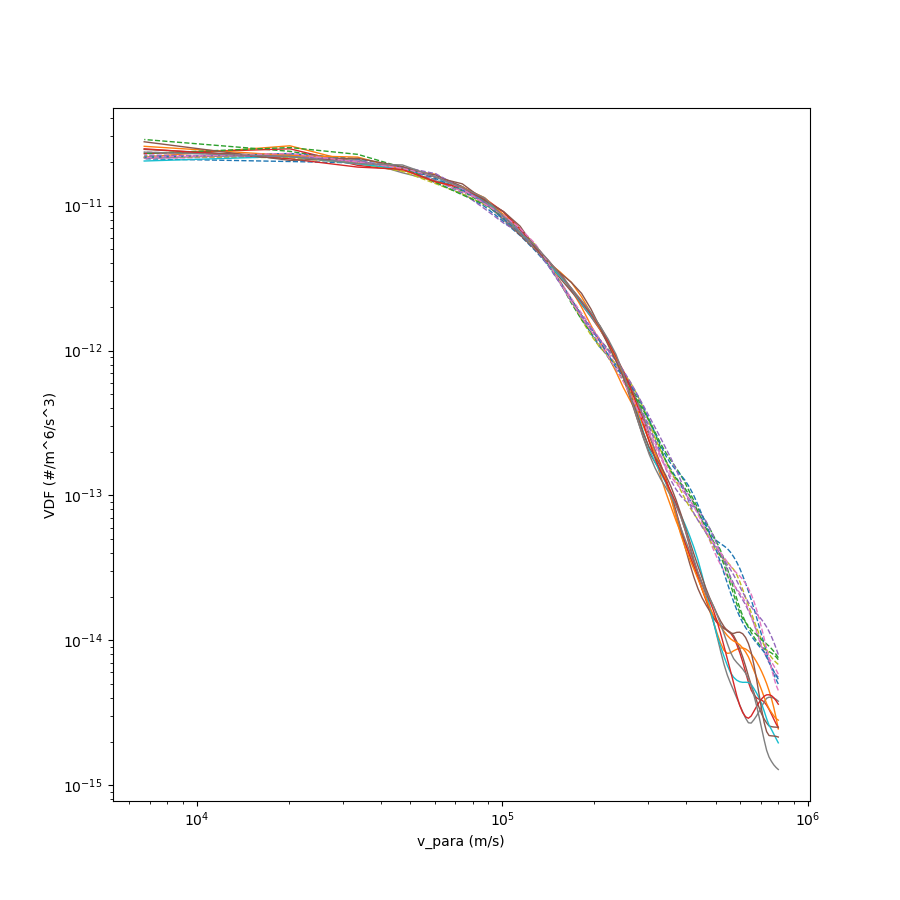

In [21]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,9))

ind_mid = int(resolution/2.)

for d in vdf_time:
    ax.loglog(-1.*centers_vz[:ind_mid], np.nanmean(d, axis=0)[:ind_mid], '--', lw=1)
    ax.loglog(centers_vz[ind_mid:], np.nanmean(d, axis=0)[ind_mid:], lw=1)
ax.set_xlabel('v_para (m/s)')
ax.set_ylabel('VDF (#/m^6/s^3)')

plt.show()